In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import math
import time

In [2]:
#read the dataset and display it.
data = pd.read_csv("data/House_Rent_Dataset.csv")

# change RUPI to TRY for better understanding
conversion_rate = 0.23
data["Rent"] = data["Rent"] * conversion_rate

data.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,2300.0,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,4600.0,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,3910.0,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,2300.0,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,1725.0,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [3]:
#Check for missing values
print(data.isna().sum())

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64


In [4]:
print(f'Number of rows before dropping duplicates: {len(data)}\n'
      f'Number of rows after dropping duplicates:  {len(data.drop_duplicates())}')

Number of rows before dropping duplicates: 4746
Number of rows after dropping duplicates:  4746


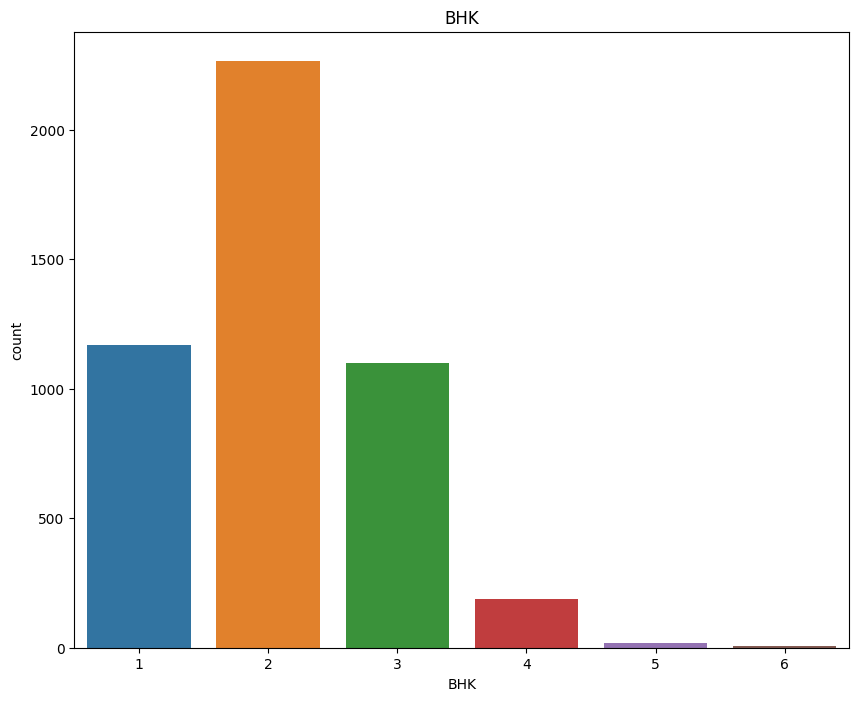

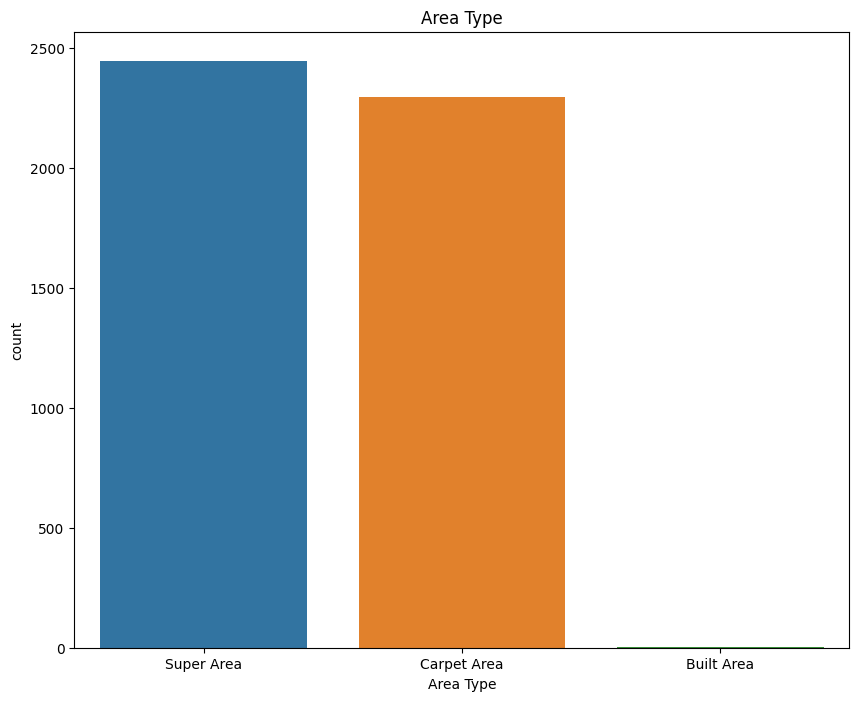

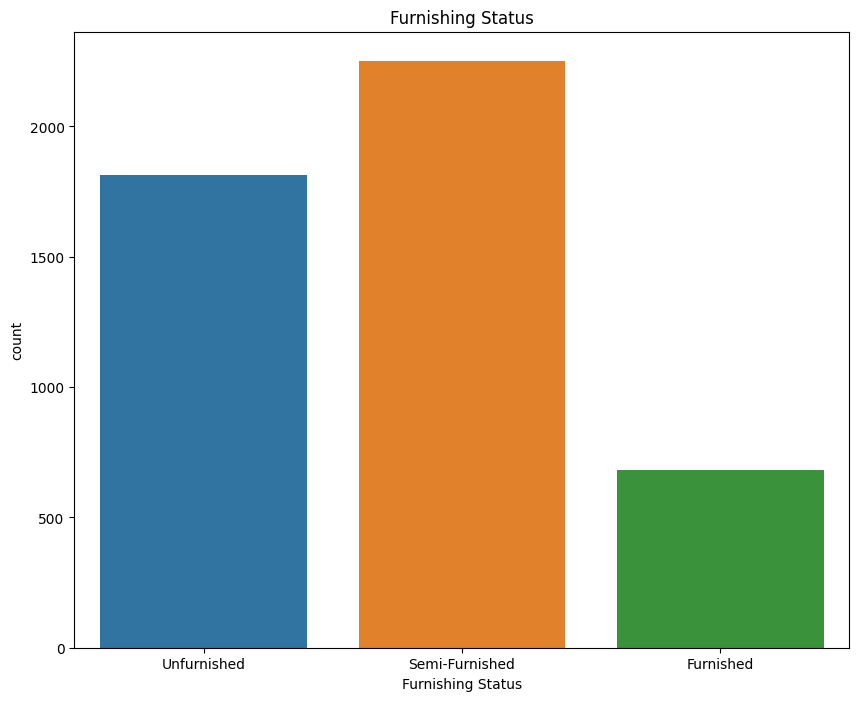

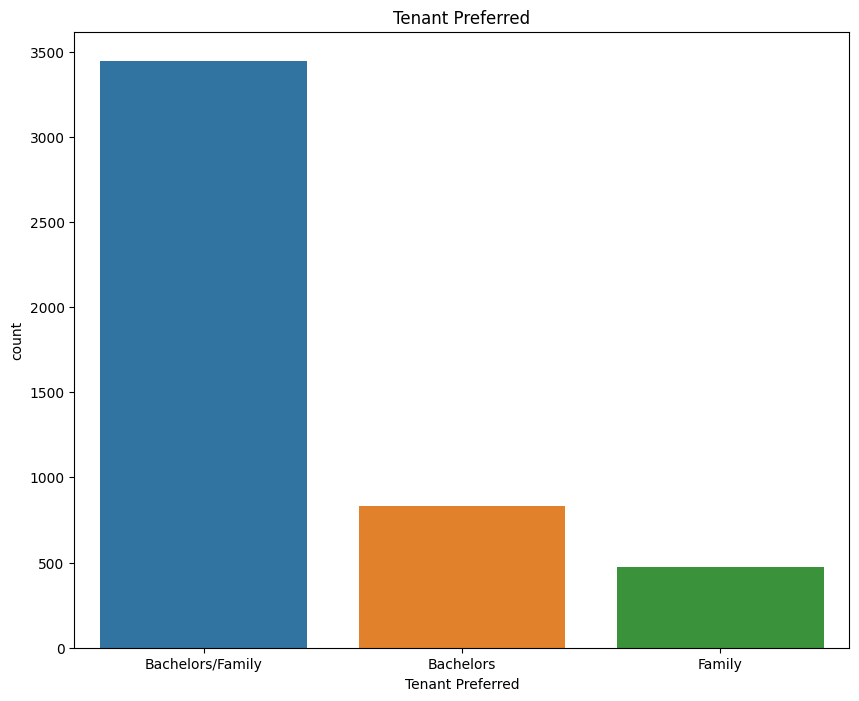

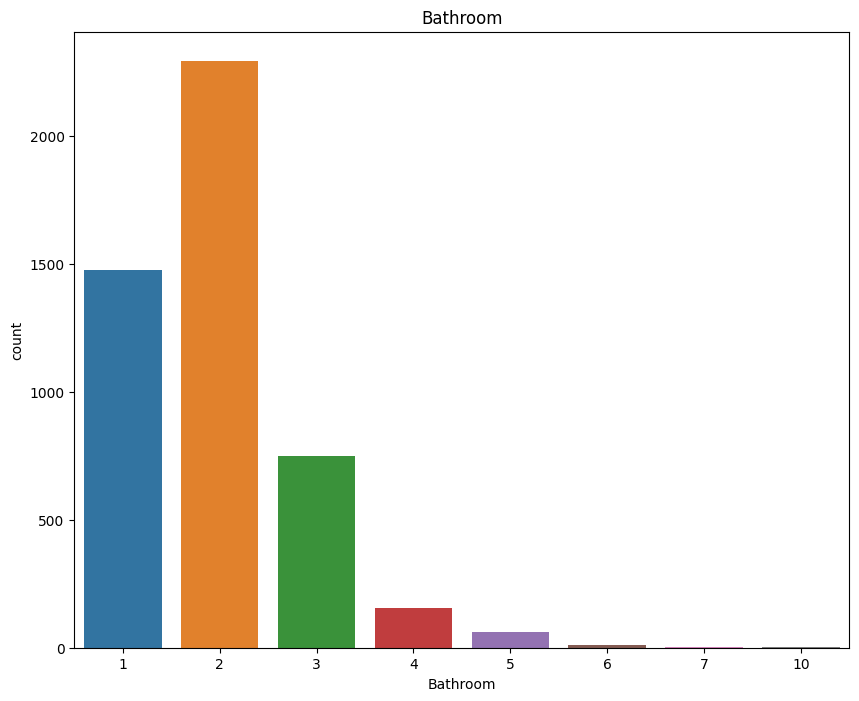

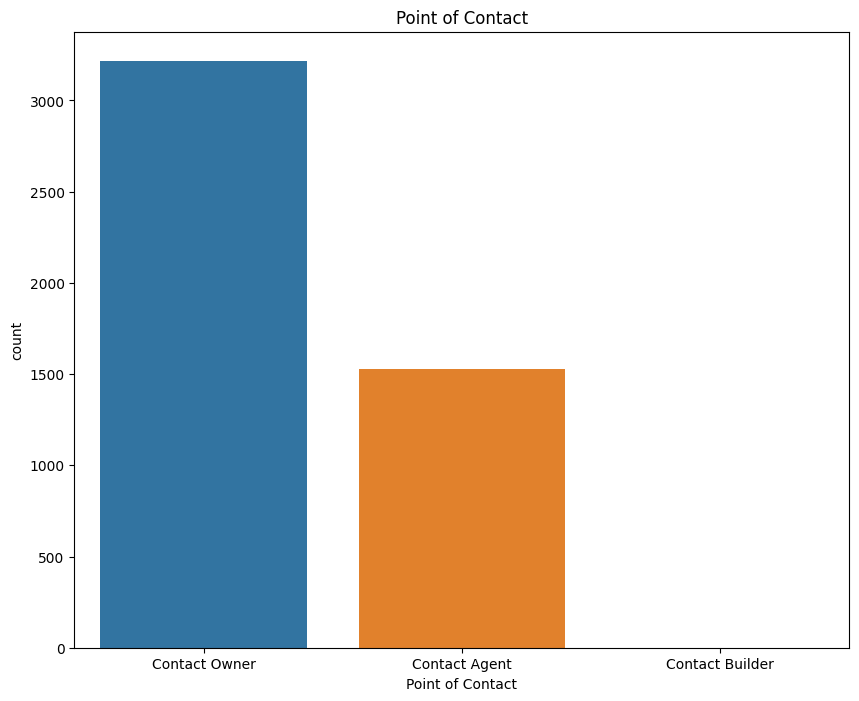

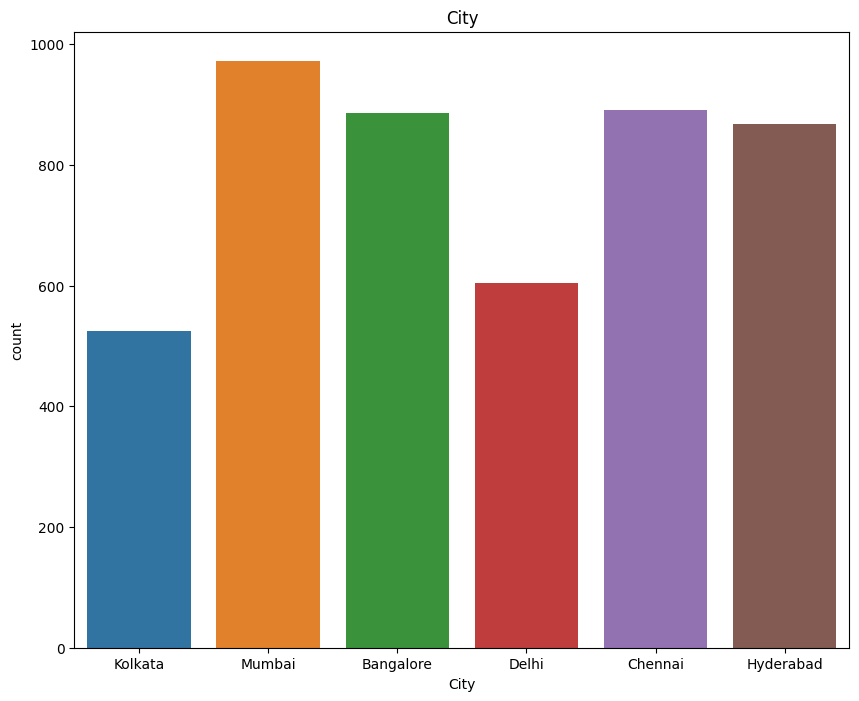

In [5]:
####################### VISUALIZE COLUMNS

columns = ['BHK','Area Type','Furnishing Status','Tenant Preferred','Bathroom','Point of Contact','City']

for column in columns:
    plt.subplots(figsize = (10,8))
    ax=sns.countplot(x=column,data=data)
    plt.title(column)
    leg=ax.get_legend()

In [6]:
####################### CONVERTING CATEGORICAL VARIABLES TO NUMERICAL VALUES USING ONE HOT ENCODER

# Remove the rows where the "Point of Contact" column is "Contact Builder" because they're outliers, not enough values.
data = data[data["Point of Contact"] != "Contact Builder"]

# Remove the rows where the "Area Type" column is "Built Area" because they're outliers, not enough values.
data = data[data["Area Type"] != "Built Area"]

# Create new numerical columns for "Bachelors\Family", "Family", "Carpet Area", "Furnished", "Contact Owner"
values = ["Family","Bachelors/Family","Carpet Area","Furnished","Contact Owner"]
columns = ['Tenant Preferred','Tenant Preferred','Area Type','Furnishing Status','Point of Contact']

for i in range(len(columns)):
    data[values[i]] = 0
    data.loc[data[columns[i]] == values[i], values[i]] = 1
    
for i in range(1,len(columns)):
    data = data.drop(columns[i], axis=1)

Mumbai       972
Chennai      890
Bangalore    886
Hyderabad    866
Delhi        605
Kolkata      524
Name: City, dtype: int64


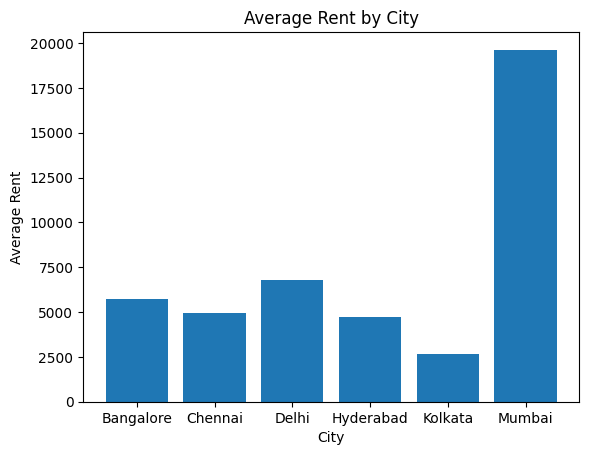

In [7]:
#analyze cities

cities=data["City"].value_counts()
print(cities)

grouped_city = data.groupby("City")

# Calculate the average "Rent" for each group
average_rent = grouped_city["Rent"].mean()

# Create a bar graph of the average rent for each city
plt.bar(average_rent.index, average_rent.values)

# Add x- and y-labels
plt.xlabel('City')
plt.ylabel('Average Rent')

# Add a title to the graph
plt.title('Average Rent by City')

# Display the graph
plt.show()

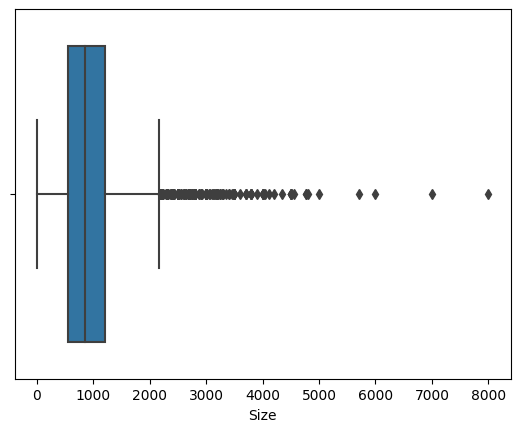

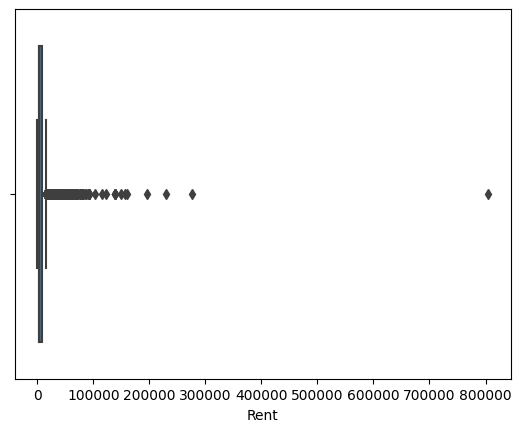

In [8]:
####################### OUTLIER DETECTION
sns.boxplot(x=data["Size"])
plt.show()

sns.boxplot(x=data["Rent"])
plt.show()

In [9]:
# Store the number of rows before removing outliers
n_before = data.shape[0]

q1, q3 = np.percentile(data['Rent'], [25, 75])
iqr = q3 - q1

# Define the lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# show
data_IQR_lb = data[(data['Rent'] > lower_bound)]
data_IQR_ub = data[(data['Rent'] < upper_bound)]

# Store the number of rows if removing outliers
n_after_lb = data_IQR_lb.shape[0]
n_after_ub = data_IQR_ub.shape[0]

# Print the number of rows removed
print("values less than lower border: ",n_before - n_after_lb)
print("values greater than upper border: ",n_before - n_after_ub)

values less than lower border:  0
values greater than upper border:  520


In [10]:
# considering a threshold for each city
city_thresholds = data[data['Furnished'] == 1].groupby('City')['Rent'].apply(lambda x: 1.5 * (x.quantile(0.75)-x.quantile(0.25)))\
    + data[data['Furnished'] == 1].groupby('City')['Rent'].quantile(0.75)
city_thresholds = city_thresholds.reset_index()
city_thresholds

,City,Rent
0,Bangalore,12592.5
1,Chennai,13857.5
2,Delhi,15812.5
3,Hyderabad,13110.0
4,Kolkata,7820.0
5,Mumbai,59225.0


deleted 270 values


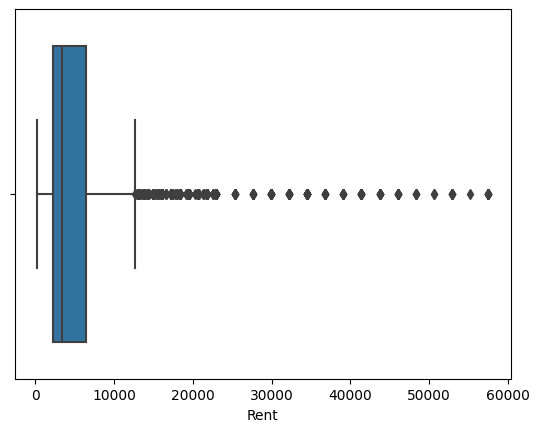

In [11]:
# Delete values higher than these thresholds
for i in range(len(city_thresholds)):
    data = data.drop(data.loc[(data['Rent'] > city_thresholds.iloc[i, 1]) 
                                             & (data['City'] == city_thresholds.iloc[i, 0])].index)
print(f'deleted {4746 - len(data)} values') 

sns.boxplot(x=data["Rent"])
plt.show()

In [12]:
# Apply one-hot encoding to the "city" column
one_hot = pd.get_dummies(data["City"])

# Add the encoded columns to the original DataFrame
data = pd.concat([data, one_hot], axis=1)

# Drop the original "city" column
data = data.drop("City", axis=1)


data.head()

,Posted On,BHK,Rent,Size,Floor,Area Locality,Bathroom,Family,Bachelors/Family,Carpet Area,Furnished,Contact Owner,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai
0,2022-05-18,2,2300.0,1100,Ground out of 2,Bandel,2,0,1,0,0,1,0,0,0,0,1,0
1,2022-05-13,2,4600.0,800,1 out of 3,"Phool Bagan, Kankurgachi",1,0,1,0,0,1,0,0,0,0,1,0
2,2022-05-16,2,3910.0,1000,1 out of 3,Salt Lake City Sector 2,1,0,1,0,0,1,0,0,0,0,1,0
3,2022-07-04,2,2300.0,800,1 out of 2,Dumdum Park,1,0,1,0,0,1,0,0,0,0,1,0
4,2022-05-09,2,1725.0,850,1 out of 2,South Dum Dum,1,0,0,1,0,1,0,0,0,0,1,0


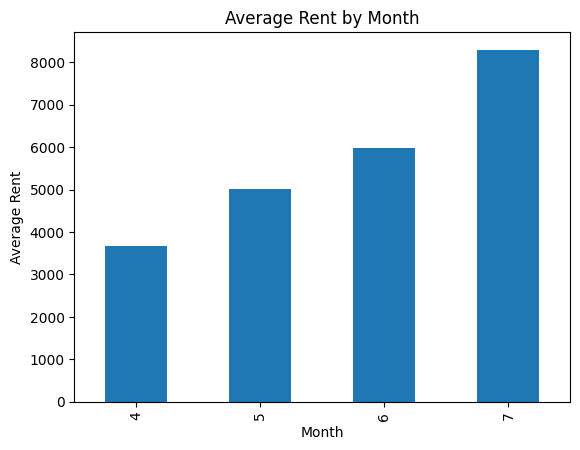

In [13]:
# Convert the date column to a datetime object
data['Posted On'] = pd.to_datetime(data['Posted On'])

# Extract the month from the date column
data['Month'] = data['Posted On'].dt.month

# Group the data by month and calculate the average Rent for each month
average_rent_by_month = data.groupby('Month')['Rent'].mean()

# Print the results
average_rent_by_month.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Rent')
plt.title('Average Rent by Month')
plt.show()

In [14]:
data['Is_Summer'] = np.where((data['Month'] >= 6) & (data['Month'] <= 8), 1, 0)
data = data.drop("Month", axis=1)
data = data.drop("Posted On", axis=1)

In [15]:
#too many different values
data = data.drop("Area Locality", axis=1)
data.head()

,BHK,Rent,Size,Floor,Bathroom,Family,Bachelors/Family,Carpet Area,Furnished,Contact Owner,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Is_Summer
0,2,2300.0,1100,Ground out of 2,2,0,1,0,0,1,0,0,0,0,1,0,0
1,2,4600.0,800,1 out of 3,1,0,1,0,0,1,0,0,0,0,1,0,0
2,2,3910.0,1000,1 out of 3,1,0,1,0,0,1,0,0,0,0,1,0,0
3,2,2300.0,800,1 out of 2,1,0,1,0,0,1,0,0,0,0,1,0,1
4,2,1725.0,850,1 out of 2,1,0,0,1,0,1,0,0,0,0,1,0,0


In [16]:
# Split the "Floor" column into two separate columns
data[["Floor Number", "Number of Floor"]] = data["Floor"].str.split(" out of ", expand=True)

# If Floor Number is "Ground" change it to 0
data.loc[data['Floor Number'] == 'Ground', 'Floor Number'] = 0

# If Floor Number is "Upper Basement" change it to 0
data.loc[data['Floor Number'] == 'Upper Basement', 'Floor Number'] = -1

# If Floor Number is "Lower Basement" change it to 0
data.loc[data['Floor Number'] == 'Lower Basement', 'Floor Number'] = -2

# Convert the "Floor Number" column to numeric
data["Floor Number"] = pd.to_numeric(data["Floor Number"])

# Convert the "Number of Floor" column to numeric
data["Number of Floor"] = pd.to_numeric(data["Number of Floor"])
data = data.drop("Floor", axis=1)
data.head()

,BHK,Rent,Size,Bathroom,Family,Bachelors/Family,Carpet Area,Furnished,Contact Owner,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Is_Summer,Floor Number,Number of Floor
0,2,2300.0,1100,2,0,1,0,0,1,0,0,0,0,1,0,0,0,2.0
1,2,4600.0,800,1,0,1,0,0,1,0,0,0,0,1,0,0,1,3.0
2,2,3910.0,1000,1,0,1,0,0,1,0,0,0,0,1,0,0,1,3.0
3,2,2300.0,800,1,0,1,0,0,1,0,0,0,0,1,0,1,1,2.0
4,2,1725.0,850,1,0,0,1,0,1,0,0,0,0,1,0,0,1,2.0


Text(0.5, 1.0, 'Correlation Heatmap')

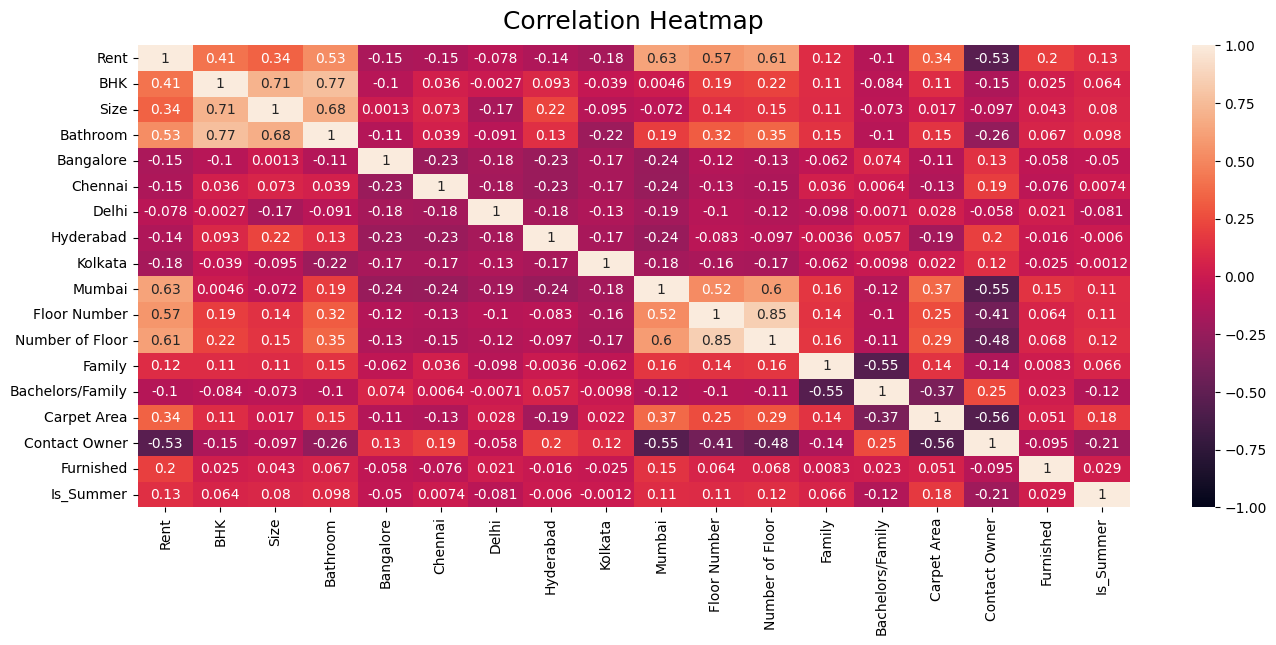

In [17]:
columns = ["Rent", "BHK", "Size", "Bathroom","Bangalore","Chennai","Delhi","Hyderabad","Kolkata","Mumbai","Floor Number","Number of Floor","Family","Bachelors/Family","Carpet Area","Contact Owner","Furnished","Is_Summer"]

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data[columns].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)


In [18]:
print("Mean Floor : ",data["Floor Number"].mean())
print("Median Floor : ",data["Floor Number"].median())
print("Highest Floor : ",data["Floor Number"].max())
print("Lowest Floor : ",data["Floor Number"].min())

print("Mean Floor Count : ",data["Number of Floor"].mean())
print("Median Floor Count: ",data["Number of Floor"].median())
print("Highest Floor Count: ",data["Number of Floor"].max())
print("Lowest Floor Count: ",data["Number of Floor"].min())

Mean Floor :  3.2410634495084896
Median Floor :  2.0
Highest Floor :  65
Lowest Floor :  -2
Mean Floor Count :  6.6211985688729875
Median Floor Count:  4.0
Highest Floor Count:  78.0
Lowest Floor Count:  1.0


Text(0.5, 1.0, 'Floor Count Distribution')

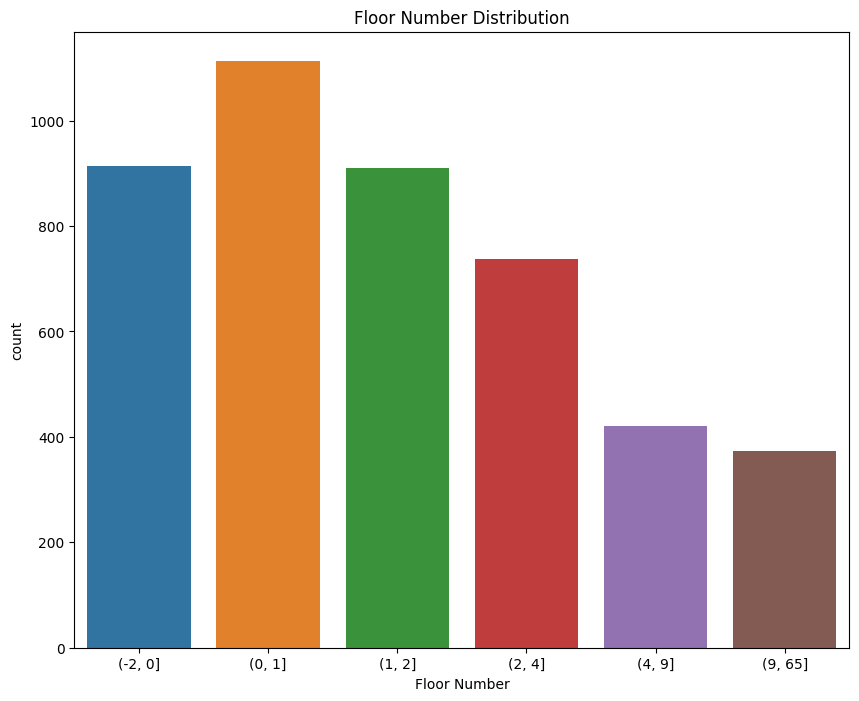

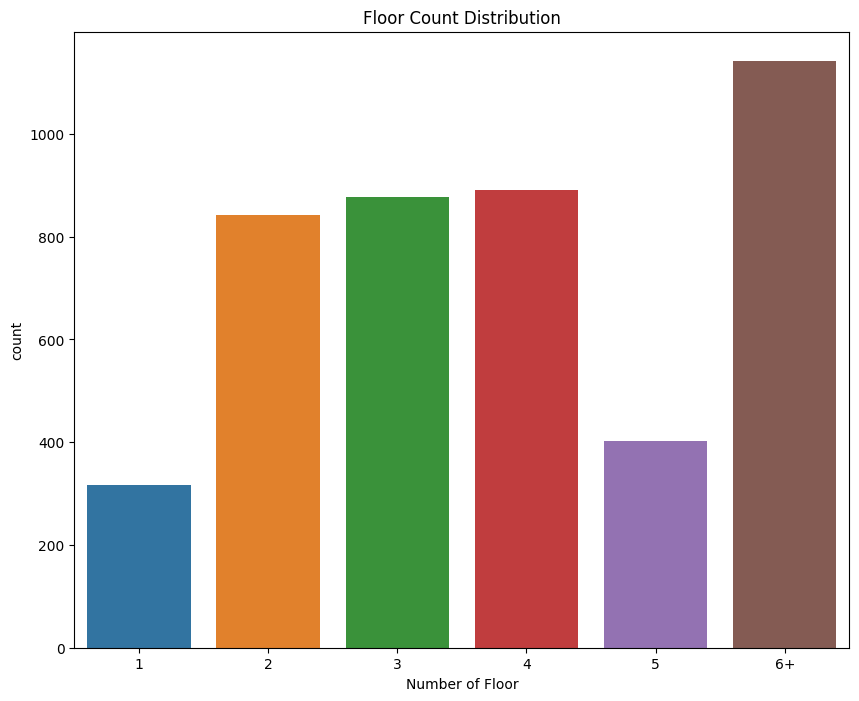

In [19]:
# Categorize the "floor number" column
data["Floor Number"] = pd.cut(data["Floor Number"], 
                              bins=[-2, 0, 1, 2, 4, 9, max(data["Floor Number"])])

# Categorize the "Floor Number" column
data["Number of Floor"] = pd.cut(data["Number of Floor"], 
                                 bins=[0, 1, 2, 3, 4, 5, max(data["Number of Floor"])], 
                                 labels=["1", "2", "3", "4", "5", "6+"])
plt.subplots(figsize = (10,8))
ax=sns.countplot(x='Floor Number',data=data)
plt.title("Floor Number Distribution")

plt.subplots(figsize = (10,8))
ax=sns.countplot(x='Number of Floor',data=data)
plt.title("Floor Count Distribution")

In [20]:
data.head()

,BHK,Rent,Size,Bathroom,Family,Bachelors/Family,Carpet Area,Furnished,Contact Owner,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Is_Summer,Floor Number,Number of Floor
0,2,2300.0,1100,2,0,1,0,0,1,0,0,0,0,1,0,0,"(-2, 0]",2
1,2,4600.0,800,1,0,1,0,0,1,0,0,0,0,1,0,0,"(0, 1]",3
2,2,3910.0,1000,1,0,1,0,0,1,0,0,0,0,1,0,0,"(0, 1]",3
3,2,2300.0,800,1,0,1,0,0,1,0,0,0,0,1,0,1,"(0, 1]",2
4,2,1725.0,850,1,0,0,1,0,1,0,0,0,0,1,0,0,"(0, 1]",2


In [21]:
# Create one-hot encoded columns for the "floor number" column
floor_dummies = pd.get_dummies(data["Floor Number"], prefix="Floor")

# Add the one-hot encoded columns to the dataframe
data = pd.concat([data, floor_dummies], axis=1)

floorcount_dummies = pd.get_dummies(data["Number of Floor"], prefix="FloorCount")

data = pd.concat([data, floorcount_dummies], axis=1)


data = data.drop("Floor Number", axis=1)
data = data.drop("Number of Floor", axis=1)


pd.options.display.max_columns = None
data.head()

,BHK,Rent,Size,Bathroom,Family,Bachelors/Family,Carpet Area,Furnished,Contact Owner,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Is_Summer,"Floor_(-2, 0]","Floor_(0, 1]","Floor_(1, 2]","Floor_(2, 4]","Floor_(4, 9]","Floor_(9, 65]",FloorCount_1,FloorCount_2,FloorCount_3,FloorCount_4,FloorCount_5,FloorCount_6+
0,2,2300.0,1100,2,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,2,4600.0,800,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,2,3910.0,1000,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,2,2300.0,800,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0
4,2,1725.0,850,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [22]:
# define a dictionary of different models
models = {'Random Forest': RandomForestRegressor(),
          'XGBoost': XGBRegressor(), 
          'Linear Regression': LinearRegression(),
          'Ridge': Ridge(),
          'Lasso': Lasso(),
          'ElasticNet': ElasticNet(alpha=0.3)
         }
# prepare data
X = data
X = X.drop("Rent", axis=1)
y = data['Rent']

X.columns = X.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# create a empty dataframe to store results
results = pd.DataFrame(columns=['Model', 'R2 Score', 'MAE', 'MSE', 'RMSE', 'Time'])

# fit and evaluate each model
for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    t1 = time.time() - t0
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'R2 Score': [r2], 'MAE': [mae], 'MSE': [mse], 'RMSE': [rmse], 'Time': [t1]})], ignore_index=True)

results

,Model,R2 Score,MAE,MSE,RMSE,Time
0,Random Forest,0.842995,1696.577383,1.023027e+07,3198.479034,0.880253
1,XGBoost,0.839327,1722.320401,1.046927e+07,3235.624525,0.147826
2,Linear Regression,0.640535,2718.987793,2.342232e+07,4839.660829,0.022507
3,Ridge,0.640309,2719.508921,2.343703e+07,4841.181094,0.029836
4,Lasso,0.640187,2720.239237,2.344502e+07,4842.005922,0.235567
5,ElasticNet,0.586757,2683.490052,2.692643e+07,5189.068048,0.143759
